## Poisson equation
This notebook contains the code for solving the following stochastic Poisson equation using the PINN-PC framework

### Equation
$-\frac{d^2 u}{dx^2} = f(x,w)$  
$u(-1) = u(1) = 0$  
$f(x,w) \sim GP(f_0(x), k(x,x'))$  
$f_0(x) = 10 \sin(\pi x)$  
$k(x,x') = \sigma^2 \exp\left(-\frac{(x-x')^2}{l^2}\right)$

Where:  
$\sigma = 1$ and $l = 0.5$

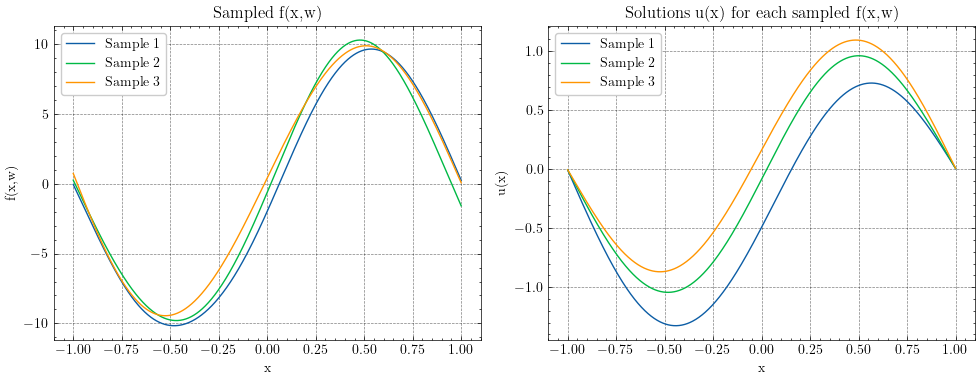

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

#nice plots, optional
import scienceplots
plt.style.use(['science', 'grid'])

# Define parameters
sigma = 1
l = 0.5
n_points = 1000
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

# Define the mean function and the kernel
f0 = lambda x: 10 * np.sin(np.pi * x)

def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Sample from the GP
def sample_GP(x, n_samples=1):
    mu = f0(x)
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    return np.random.multivariate_normal(mu, K, n_samples)

# Finite differences using scipy's sparse matrix to solve the Poisson equation
def solve_poisson(f, dx, u_left=0, u_right=0):
    N = len(f)
    diagonals = [-2 * np.ones(N), np.ones(N - 1), np.ones(N - 1)]
    A = diags(diagonals, [0, 1, -1], format="csr")
    A = A / dx**2

    # Set boundary conditions
    f[0] += u_left / dx**2
    f[-1] += u_right / dx**2

    u = spsolve(A, -f)
    return u

# Sample f(x,w) and solve the Poisson equation for each sample
n_samples = 3
f_samples = sample_GP(x, n_samples)
u_solution = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples])

plt.figure(figsize=(10, 4))

# Left subplot for f(x,w)
plt.subplot(1, 2, 1)
for i in range(n_samples):
    plt.plot(x, f_samples[i], label=f"Sample {i+1}")
plt.title("Sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('f(x,w)')
plt.legend()

# Right subplot for u(x)
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x, u_solution[i], label=f"Sample {i+1}")
plt.title("Solutions u(x) for each sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

plt.tight_layout()
plt.show()

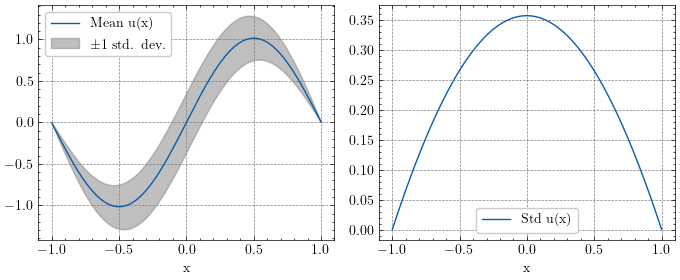

In [7]:
# Monte Carlo approximation of the mean and standard deviation of the solution

n_points = 1000
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

n_samples = 10000
f_samples = sample_GP(x, n_samples) # Matrix of shape (n_samples, n_points)
u_solution = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples]) # Matrix of shape (n_samples, n_points)

# Calculate the mean and standard deviation along the sample axis
u_mean = u_solution.mean(axis=0)
u_std = u_solution.std(axis=0)

# Plot the mean and standard deviation side by side
fig = plt.figure(figsize=(7, 3))

# Left subplot for mean of u(x)
plt.subplot(1, 2, 1)
plt.plot(x, u_mean, label="Mean u(x)")
plt.fill_between(x, u_mean - u_std, u_mean + u_std, color='gray', alpha=0.5, label="±1 std. dev.")
# plt.title("Mean Solution u(x)")
plt.xlabel('x')
plt.legend()

# Right subplot for standard deviation of u(x)
plt.subplot(1, 2, 2)
plt.plot(x, u_std, label="Std u(x)")
# plt.title("Standard Deviation of Solutions u(x)")
plt.xlabel('x')
plt.legend()

plt.tight_layout()
plt.show()
# fig.savefig('figures/MonteCarlo_mean_std.pdf', bbox_inches='tight')

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_557/3700772992.py:32: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Explained Variance (\%)')
/tmp/ipykernel_557/3700772992.py:46: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x, eigenvectors[:, i], label="$\lambda_{}$ = {:.2f}".format(i+1, eigenvalues[i]))


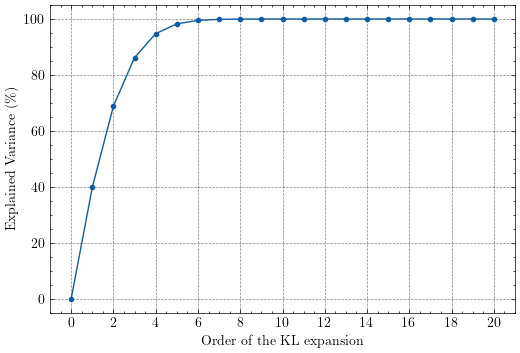

99.0% of variance explained with 6 modes


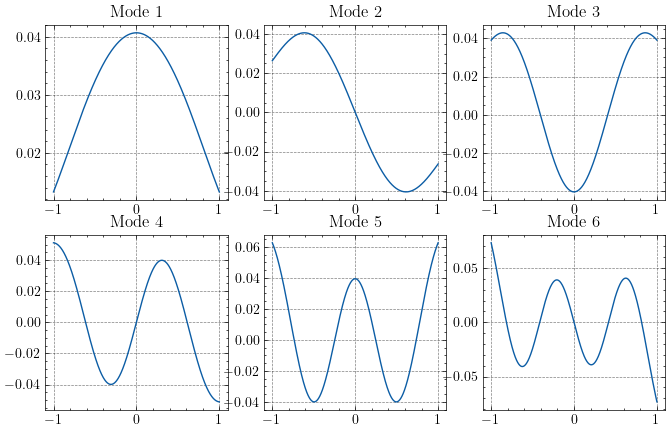

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Define the GP kernel
def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)


def KL_expansion(x, kernel,truncation_order):
    """Compute the KL expansion of the GP prior defined by the kernel function."""
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    eigenvalues, eigenvectors = eigh(K)#,driver='evx')
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    for i in range(truncation_order):
        if eigenvectors[0, i] < 0:
            eigenvectors[:, i] *= -1 # Eigenvectors are defined up to a scalar factor
    return eigenvalues[:truncation_order], eigenvectors[:, :truncation_order]

eigenvalues, eigenvectors = KL_expansion(x, kernel, truncation_order=20)

# Compute the cumulative explained variance
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues) 

# Plot explained variance
fig = plt.figure(figsize=(6, 4))
n_orders = 20
plt.plot(np.arange(0, n_orders + 1), [0] + list(explained_variance[:n_orders] * 100), marker='.')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance (\%)')
# plt.title('Explained Variance vs. Order of KL Expansion')
plt.xticks(np.arange(0, n_orders + 1, 2))
plt.show()
# fig.savefig('figures/KL_explained_variance.pdf', format='pdf')
    
# Propose truncation order based on a threshold
threshold = 0.99  # Example threshold for 99% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"{threshold*100}% of variance explained with {truncation_order} modes")

# Plot the first 6 modes
fig, axs = plt.subplots(2, int(truncation_order/2), figsize=(8, 5))
for i, ax in enumerate(axs.flat):
    ax.plot(x, eigenvectors[:, i], label="$\lambda_{}$ = {:.2f}".format(i+1, eigenvalues[i]))
    ax.set_title(f"Mode {i+1}")
    # ax.legend()
# fig.savefig('figures/KL_modes.pdf', format='pdf')


In [16]:
import time
from tqdm import tqdm
#approximating PCE modes by Monte Carlo
def f_from_xi(xi, x_train, eigenvalues, eigenvectors, f0):
    """Compute the function f(x) from the random variables xi."""
    f_stoch = np.sqrt(eigenvalues) * xi @ eigenvectors.T
    f = f0(x_train) + f_stoch
    return f

t_start = time.time()
seed = 42
n_xi_samples = int(1e3) #number of samples
n_x_points = 1000 #spatial discretization
truncation_order = 6
modes_function = np.zeros((truncation_order, n_x_points))

x_test = np.linspace(-1, 1, n_x_points)
dx = x_test[1] - x_test[0]
eigenvalues, eigenvectors = KL_expansion(x_test, kernel, truncation_order)

np.random.seed(seed) # Set seed for reproducibility
xi_test = np.random.randn(n_xi_samples, truncation_order)

print("f samples :")
f_samples = [f_from_xi(xi, x_test, eigenvalues, eigenvectors, f0) for xi in tqdm(xi_test)]
print("u resolution :")
u_solution = np.array([solve_poisson(f_sample, dx) for f_sample in tqdm(f_samples)]) # Matrix of shape (n_samples, n_points)
u_mean = u_solution.mean(axis=0) # = f0(x_test)/np.pi**2 
u_stoch = u_solution - u_mean
modes_function = np.zeros((truncation_order, len(x_test)))
for mode in range(0,truncation_order):
    xi_mode = xi_test[:,mode]
    modes_function[mode,:] = np.sum(xi_test[:,mode].reshape(-1,1) * u_stoch, axis=0)/n_xi_samples

print(f"Time taken: {time.time() - t_start:.2f} s")

f samples :


100%|██████████| 1000/1000 [00:00<00:00, 28514.06it/s]


u resolution :


100%|██████████| 1000/1000 [00:00<00:00, 1284.93it/s]

Time taken: 2.24 s


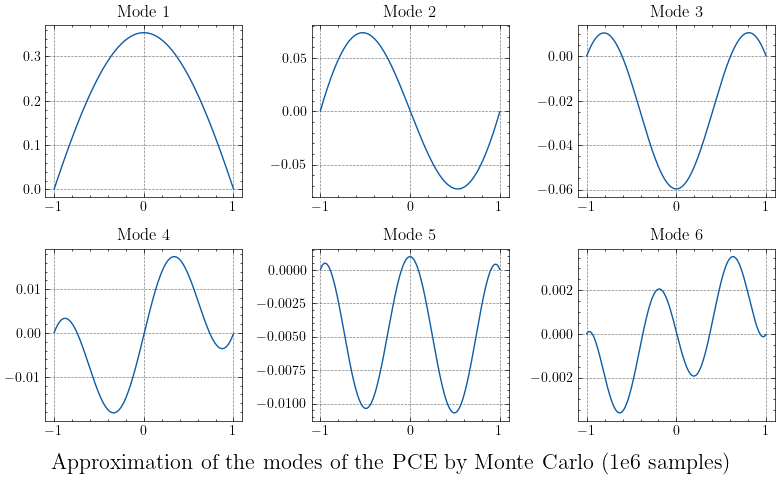

In [11]:
#save the reference solution
save = False
if save:
    np.save(f'MonteCarlo_PCE_modes_1e{np.log10(n_xi_samples)}.npy', modes_function)

# MonteCarlo_PCE_modes = modes_function
MonteCarlo_PCE_modes = np.load('MonteCarlo_PCE_modes_1e6.0.npy')

fig, axs = plt.subplots(2, int(len(MonteCarlo_PCE_modes)/2), figsize=(8, 5))
for i, mode in enumerate(MonteCarlo_PCE_modes):
    i_row = i // (len(MonteCarlo_PCE_modes) // 2)
    i_col = i % (len(MonteCarlo_PCE_modes) // 2)
    axs[i_row, i_col].plot(x_test, mode)
    axs[i_row, i_col].set_title(f"Mode {i + 1}")
plt.suptitle(f"Approximation of the modes of the PCE by Monte Carlo (1e6 samples)", y=0, fontsize=16)
plt.tight_layout()
plt.show()
# fig.savefig('figures/MonteCarlo_PCE_modes.pdf', format='pdf')

Monte Carlo converges in $O(N^{-1/2})$ where $N$ is the number of samples.
To be able to approximate modes 6 (order of magnitude $10^{-3}$) we need at least $10^6$ samples

## Implementation of the PINN-PC framework

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0][:, None, i].flatten()
print("Using GPU:", torch.cuda.is_available())

Using GPU: True


In [122]:
def f0(x):
    if isinstance(x, torch.Tensor):
        return 10 * torch.sin(torch.pi * x)
    else:
        return 10 * np.sin(np.pi * x)
    
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=4):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class PCECoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(PCECoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def l2_regularization(model, lambda_reg=1e-3):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return lambda_reg * l2_reg
    
def compute_loss(x, xi,f, mean_model, coeffs_model, batch_size):

    indices = torch.randperm(xi.size(0))[:batch_size]
    xi_batch = xi[indices]
    f_batch = f[indices]
    loss = 0

    u_predicted = mean_model(x).flatten() + xi_batch @  coeffs_model(x).T
    du_dx_mean = grad_i(mean_model(x).flatten(), x, 0)
    d2u_d2x_mean = grad_i(du_dx_mean, x, 0)
    d2u_dx2_coeffs = []
    for i in range(coeffs_model(x).shape[1]):  # Loop over the columns (6 in this case)
        grad = grad_i(coeffs_model(x)[:, i], x, 0)
        grad2 = grad_i(grad, x, 0)
        d2u_dx2_coeffs.append(grad2)

    d2u_dx2_coeffs = torch.stack(d2u_dx2_coeffs, dim=1).squeeze()
    d2u_dx2 = d2u_d2x_mean + xi_batch @ d2u_dx2_coeffs.T

    pde_residual = d2u_dx2 + f_batch
    pde_loss = torch.mean(pde_residual**2) 

    bc_loss_left = torch.mean(u_predicted[:, 0]**2)
    bc_loss_right = torch.mean(u_predicted[:, -1]**2)
    bc_loss = (bc_loss_left + bc_loss_right) / 2

    loss = pde_loss + bc_loss
    return loss

 

In [128]:
def train(mean_model, coeffs_model, data, batch_size=100, optimizer_choice="adam", epochs=1000, lr=0.001, lambda_reg=1e-4):
    t_start = time.time()
    x_torch, xi_torch, f_torch = data
    if optimizer_choice == "adam":
        optimizer = torch.optim.Adam(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            loss = compute_loss(x_torch, xi_torch, f_torch, mean_model, coeffs_model, batch_size)
            l2_reg = l2_regularization(mean_model,lambda_reg) + l2_regularization(coeffs_model,lambda_reg)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            
            # Print progress
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.3e}, Elapsed time: {time.time()-t_start:.0f}")
                
    elif optimizer_choice == "l-bfgs":
        optimizer = torch.optim.LBFGS(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr, max_iter=20, history_size=100)

        for epoch in range(epochs):
            def closure():
                optimizer.zero_grad()
                
                loss = compute_loss(x_torch, xi_torch, f_torch, mean_model, coeffs_model, batch_size)
                l2_reg = l2_regularization(mean_model,lambda_reg) + l2_regularization(coeffs_model,lambda_reg)
                loss += l2_reg
                loss.backward()
                return loss

            optimizer.step(closure)
            
            # Print progress
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Loss: {closure().item():.3e}, Elapsed time: {time.time()-t_start:.0f}")
    else:
        print(f"Optimizer choice {optimizer_choice} not recognized. Please choose either 'adam' or 'l-bfgs'.")

In [126]:
n_x_points = 100
n_xi_samples = 100000
n_sensors = 13
sensors_indices = np.linspace(0, n_x_points - 1, n_sensors, dtype=int)

xi_train = np.random.randn(n_xi_samples, truncation_order)
x_train = np.linspace(-1, 1, n_x_points)

eigenvalues, eigenvectors = KL_expansion(x_train, kernel, truncation_order)
f_samples = np.array([f_from_xi(xi, x_train, eigenvalues, eigenvectors, f0) for xi in xi_train])

f_torch = torch.tensor(f_samples[:,sensors_indices]).float().to(device)
xi_torch = torch.tensor(xi_train).float().to(device)
x_torch = torch.tensor(x_train[sensors_indices]).unsqueeze(-1).float().to(device)
x_torch.requires_grad = True

# Models, Loss, and Optimizer
mean_model = MeanNN(input_dim=1).to(device)
coeffs_model = PCECoefficientNN(input_dim=1, output_dim=truncation_order).to(device)

In [129]:
# Training, should take a few minutes
batch_size = 1000
learning_rate = 1e-3
lambda_reg = 1e-4
epochs = 5000

data = x_torch, xi_torch, f_torch 

train(mean_model, coeffs_model, data, batch_size=batch_size, optimizer_choice="adam", epochs=epochs, lr=learning_rate, lambda_reg=lambda_reg)
# train(mean_model, coeffs_model, data, batch_size=batch_size, optimizer_choice="l-bfgs", epochs=epochs, lambda_reg=lambda_reg)

Epoch 0, Loss: 5.958e+00, Elapsed time: 0
Epoch 1000, Loss: 4.973e-02, Elapsed time: 22
Epoch 2000, Loss: 4.854e-03, Elapsed time: 44
Epoch 3000, Loss: 3.201e-03, Elapsed time: 66
Epoch 4000, Loss: 2.814e-03, Elapsed time: 88


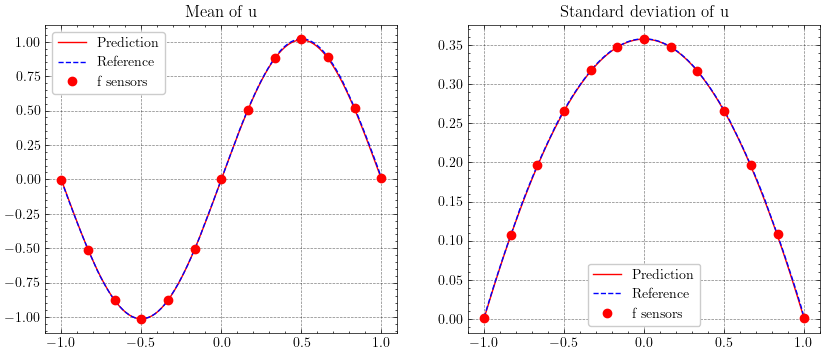

In [132]:
n_x_plot = 100
subsample_ind = [int(i) for i in np.linspace(0,len(u_std)-1,n_x_plot)]
x_sensor = np.linspace(-1, 1, n_sensors)
sensors_indices = np.linspace(0, len(u_std) - 1, n_sensors, dtype=int)
x_values = np.linspace(-1, 1, n_x_plot).reshape(-1,1)
x_tensor = torch.tensor(x_values).float().view(-1, 1).to(device)
# u_mean = f0(x_values)/np.pi**2

# Evaluate the mean_model to get the predicted mean values
with torch.no_grad():
    predicted_mean = mean_model(x_tensor).cpu().numpy()
    coeffs_output = coeffs_model(x_tensor).cpu().numpy()

model_std = np.sqrt(np.sum(coeffs_output**2, axis=1))


# Plot the comparison
fig, axs = plt.subplots(1,2,figsize=(10, 4))
axs[0].plot(x_values, predicted_mean, 'r-', label="Prediction")
axs[0].plot(x_values, u_mean[subsample_ind], 'b--', label="Reference")
axs[0].plot(x_sensor, u_mean[sensors_indices], 'ro', label="f sensors")
axs[0].legend()
axs[0].set_title('Mean of u')

axs[1].plot(x_values, model_std, 'r-', label="Prediction")
axs[1].plot(x_values, u_std[subsample_ind], 'b--', label="Reference")
axs[1].plot(x_sensor, u_std[sensors_indices], 'ro', label="f sensors")
axs[1].legend()
axs[1].set_title('Standard deviation of u')

fig.savefig('figures/PINN_mean_std.pdf', format='pdf')

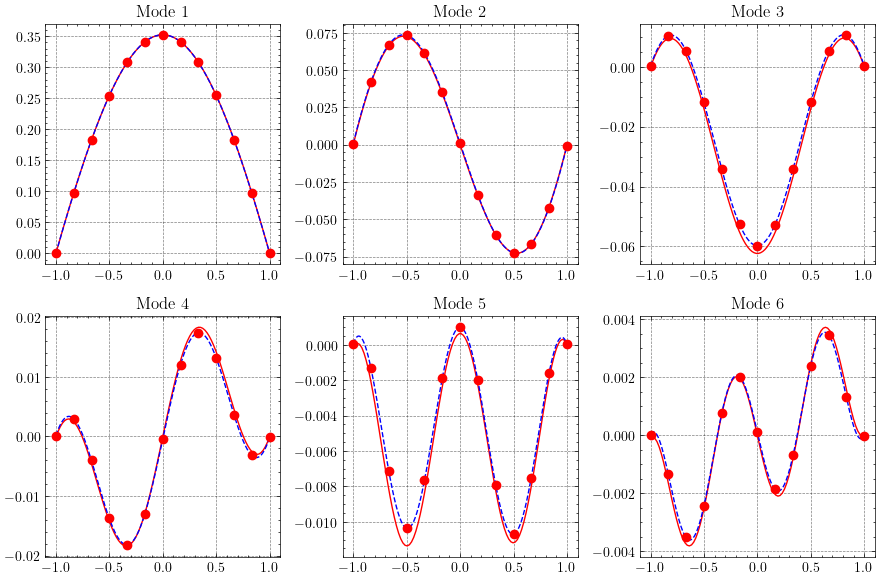

In [133]:
def plot_modes(x_values, coeffs_model, modes_to_plot, reference_modes=None):
    # Convert x_values to a PyTorch tensor
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1).to(device)
    # Evaluate the model (turn off gradient computation for evaluation)
    with torch.no_grad():
        coeffs_output = coeffs_model(x_tensor)

    # Convert the outputs back to numpy for plotting
    coeffs_numpy = coeffs_output.cpu().numpy()

    # Number of modes to plot
    num_modes = len(modes_to_plot)
    
    # Determine the layout for the subplots: 2 columns if more than 3 modes
    n_cols = num_modes if num_modes <= 3 else num_modes // 2 + num_modes % 2
    n_rows = 1 if num_modes <= 3 else 2
    
    # Create subplots for each mode
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axs = axs.flatten() if num_modes > 1 else [axs]

    for i, mode in enumerate(modes_to_plot):
        ax = axs[i]
        
        ax.plot(x_values, coeffs_numpy[:, mode-1], 'r-', label="PINN-PCE approx.")

        if reference_modes is not None:
            x_ref = np.linspace(-1, 1, len(reference_modes[mode-1,:]))
            ax.plot(x_ref, reference_modes[mode-1,:], 'b--', label="Reference")
            ax.plot(x_sensor, reference_modes[mode-1, sensors_indices], 'ro', label="f sensors")

        ax.set_title(f"Mode {mode}")
        # ax.legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()
    return fig


# Define the inputs and modes you want to visualize
# x_values = np.linspace(-1, 1, 100)
modes_to_plot = [1,2,3,4,5,6]
reference_modes = np.load('MonteCarlo_PCE_modes_1e6.0.npy')

reference_modes[0,:] = reference_modes[0,:] - np.min(reference_modes[0,:])
sensors_indices = np.linspace(0, reference_modes.shape[1] - 1, n_sensors, dtype=int)

fig = plot_modes(x_values,coeffs_model, modes_to_plot, reference_modes=reference_modes)
fig.savefig('figures/PINN_PCE_modes.pdf', format='pdf')